In [1]:
import os
import numpy as np
import pickle
import random

In [2]:
def load_cifar10_batch(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
        X = dict[b'data']
        Y = dict[b'labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y


In [3]:
def load_cifar10_data(data_dir):
    X_train = []
    Y_train = []
    
    for i in range(1, 6):
        file = os.path.join(data_dir, f'data_batch_{i}')
        X, Y = load_cifar10_batch(file)
        X_train.append(X)
        Y_train.append(Y)
    
    X_train = np.concatenate(X_train)
    Y_train = np.concatenate(Y_train)
    
    X_test, Y_test = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))
    
    return X_train, Y_train, X_test, Y_test


In [25]:
data_dir = 'cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_cifar10_data(data_dir)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


In [5]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [9]:
from tensorflow.keras.applications import ResNet50

In [14]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in base_model.layers:
    layer.trainable = False

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, AvgPool2D, Input, GlobalAveragePooling2D

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,696,138 (98.02 MB)

 Trainable params: 2,108,426 (8.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [43]:
random.seed(42)
random_indices = random.sample(range(X_train.shape[0]), 25000)

X_train_subset = X_train[random_indices]
y_train_subset = y_train[random_indices]

print(f"Subset training data shape: {X_train_subset.shape}")
print(f"Subset training labels shape: {y_train_subset.shape}")

Subset training data shape: (25000, 32, 32, 3)
Subset training labels shape: (25000,)


In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,           
    width_shift_range=0.1,       
    height_shift_range=0.1,      
    horizontal_flip=True,        
    zoom_range=0.1,              
    shear_range=0.1
)

training_data = datagen.flow(X_train_subset, y_train_subset, batch_size=60)

In [32]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
history = model.fit(
    training_data,
    epochs=100,
    validation_data=(X_test, y_test)
)

Epoch 1/100


c:\Users\sambo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


417/417 ━━━━━━━━━━━━━━━━━━━━ 92s 206ms/step - accuracy: 0.4261 - loss: 2.3122 - val_accuracy: 0.5600 - val_loss: 1.2523
Epoch 2/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 88s 211ms/step - accuracy: 0.5456 - loss: 1.2681 - val_accuracy: 0.5818 - val_loss: 1.2034
Epoch 3/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 87s 209ms/step - accuracy: 0.5742 - loss: 1.1910 - val_accuracy: 0.5782 - val_loss: 1.2076
Epoch 4/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 90s 214ms/step - accuracy: 0.5950 - loss: 1.1439 - val_accuracy: 0.5991 - val_loss: 1.1618
Epoch 5/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 86s 206ms/step - accuracy: 0.6006 - loss: 1.1310 - val_accuracy: 0.6057 - val_loss: 1.1358
Epoch 6/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 90s 216ms/step - accuracy: 0.6133 - loss: 1.0904 - val_accuracy: 0.6050 - val_loss: 1.1304
Epoch 7/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 88s 212ms/step - accuracy: 0.6213 - loss: 1.0665 - val_accuracy: 0.5971 - val_loss: 1.1609
Epoch 8/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 88s 211ms/step - accuracy: 0.6281 - loss: 1.056

In [34]:
import matplotlib.pyplot as plt

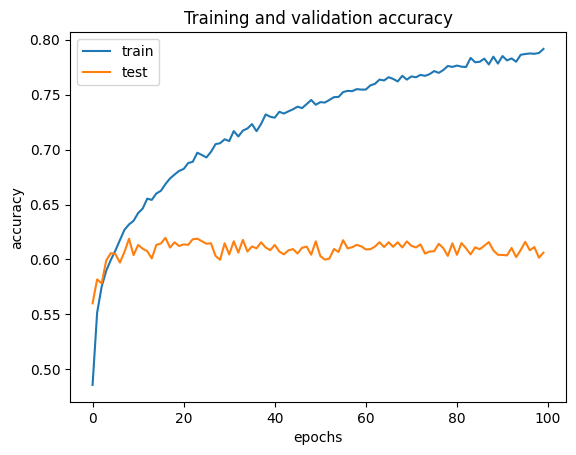

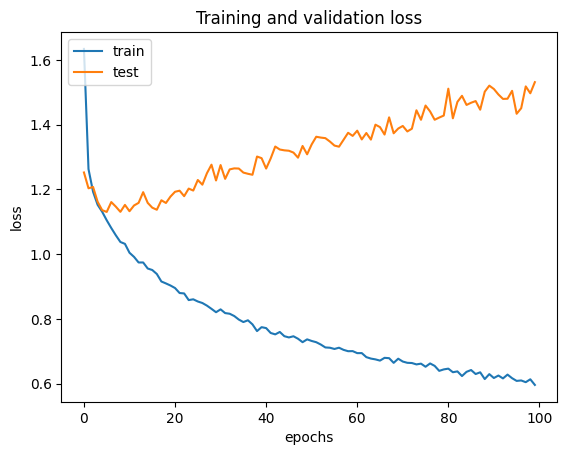

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(acc)
plt.plot(val_acc)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(loss)
plt.plot(val_loss)

plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
model.evaluate(training_data)

417/417 ━━━━━━━━━━━━━━━━━━━━ 51s 122ms/step - accuracy: 0.7948 - loss: 0.6057


[0.6057206392288208, 0.790440022945404]

In [38]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.6069 - loss: 1.5189


[1.53135085105896, 0.6061999797821045]

<h3>Second Experiment</h3>

In [55]:
model2 = Sequential()
model2.add(base_model)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(32, activation='relu'))
model2.add(Dense(10, activation='softmax'))

In [56]:
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,653,610 (90.23 MB)

 Trainable params: 65,898 (257.41 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [57]:
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [58]:
history2 = model2.fit(
    training_data,
    epochs=100,
    validation_data=(X_test, y_test)
)

Epoch 1/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 85s 191ms/step - accuracy: 0.3375 - loss: 2.0694 - val_accuracy: 0.5214 - val_loss: 1.3808
Epoch 2/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 87s 207ms/step - accuracy: 0.5181 - loss: 1.3696 - val_accuracy: 0.5585 - val_loss: 1.2721
Epoch 3/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 85s 203ms/step - accuracy: 0.5492 - loss: 1.2900 - val_accuracy: 0.5828 - val_loss: 1.2071
Epoch 4/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 87s 209ms/step - accuracy: 0.5582 - loss: 1.2462 - val_accuracy: 0.5834 - val_loss: 1.1976
Epoch 5/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 87s 209ms/step - accuracy: 0.5683 - loss: 1.2168 - val_accuracy: 0.5810 - val_loss: 1.2073
Epoch 6/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 88s 209ms/step - accuracy: 0.5694 - loss: 1.2145 - val_accuracy: 0.5902 - val_loss: 1.1705
Epoch 7/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 81s 193ms/step - accuracy: 0.5887 - loss: 1.1689 - val_accuracy: 0.5983 - val_loss: 1.1614
Epoch 8/100
417/417 ━━━━━━━━━━━━━━━━━━━━ 79s 190ms/step - accuracy: 0.5942 -

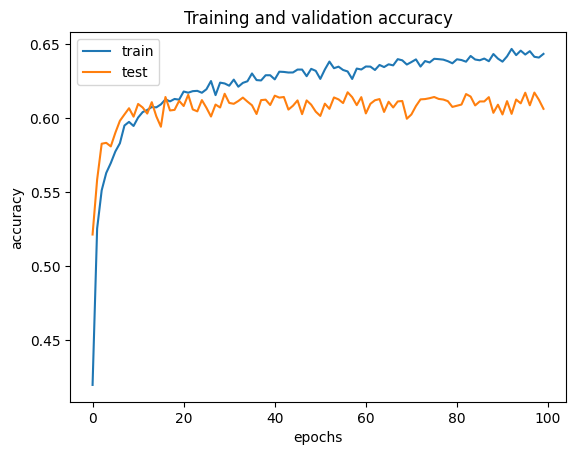

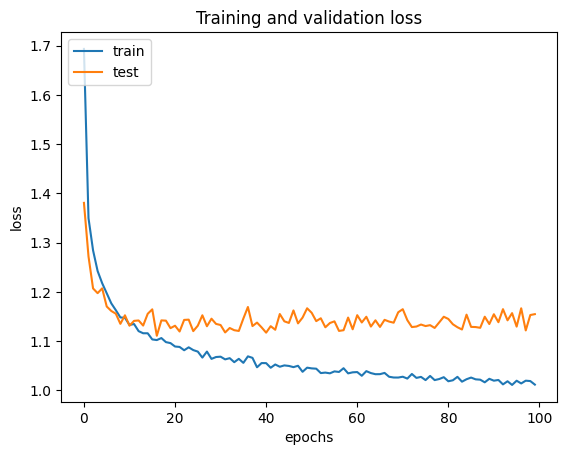

In [59]:
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
plt.plot(acc2)
plt.plot(val_acc2)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(loss2)
plt.plot(val_loss2)

plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [60]:
model2.evaluate(training_data)

417/417 ━━━━━━━━━━━━━━━━━━━━ 58s 140ms/step - accuracy: 0.6396 - loss: 1.0140


[1.0190471410751343, 0.6391199827194214]

In [61]:
model2.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.6036 - loss: 1.1567


[1.1549614667892456, 0.6064000129699707]